# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 2277376/11490434 [====>.........................] - ETA: 0s

 8396800/11490434 [====================>.........] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 11:01 - loss: 0.6929

  30/1875 [..............................] - ETA: 3s - loss: 0.5340   

  63/1875 [>.............................] - ETA: 2s - loss: 0.4516

  94/1875 [>.............................] - ETA: 2s - loss: 0.4125

 129/1875 [=>............................] - ETA: 2s - loss: 0.3847

 164/1875 [=>............................] - ETA: 2s - loss: 0.3651

 187/1875 [=>............................] - ETA: 2s - loss: 0.3548

 221/1875 [==>...........................] - ETA: 2s - loss: 0.3419

 252/1875 [===>..........................] - ETA: 2s - loss: 0.3320

 285/1875 [===>..........................] - ETA: 2s - loss: 0.3228

 317/1875 [====>.........................] - ETA: 2s - loss: 0.3149

 345/1875 [====>.........................] - ETA: 2s - loss: 0.3088

 372/1875 [====>.........................] - ETA: 2s - loss: 0.3033

 401/1875 [=====>........................] - ETA: 2s - loss: 0.2980

 431/1875 [=====>........................] - ETA: 2s - loss: 0.2929

 461/1875 [======>.......................] - ETA: 2s - loss: 0.2881

 490/1875 [======>.......................] - ETA: 2s - loss: 0.2839

 520/1875 [=======>......................] - ETA: 2s - loss: 0.2799

 549/1875 [=======>......................] - ETA: 2s - loss: 0.2762

 579/1875 [========>.....................] - ETA: 2s - loss: 0.2726

 608/1875 [========>.....................] - ETA: 2s - loss: 0.2694

 638/1875 [=========>....................] - ETA: 2s - loss: 0.2662

 667/1875 [=========>....................] - ETA: 2s - loss: 0.2633

 696/1875 [==========>...................] - ETA: 1s - loss: 0.2605

 725/1875 [==========>...................] - ETA: 1s - loss: 0.2579

 753/1875 [===========>..................] - ETA: 1s - loss: 0.2555

 778/1875 [===========>..................] - ETA: 1s - loss: 0.2534

 806/1875 [===========>..................] - ETA: 1s - loss: 0.2512

 833/1875 [============>.................] - ETA: 1s - loss: 0.2491

 863/1875 [============>.................] - ETA: 1s - loss: 0.2470

 891/1875 [=============>................] - ETA: 1s - loss: 0.2450

 920/1875 [=============>................] - ETA: 1s - loss: 0.2430

 949/1875 [==============>...............] - ETA: 1s - loss: 0.2411

 978/1875 [==============>...............] - ETA: 1s - loss: 0.2393

1006/1875 [===============>..............] - ETA: 1s - loss: 0.2376

1031/1875 [===============>..............] - ETA: 1s - loss: 0.2362

1057/1875 [===============>..............] - ETA: 1s - loss: 0.2347

1084/1875 [================>.............] - ETA: 1s - loss: 0.2332

1112/1875 [================>.............] - ETA: 1s - loss: 0.2317

1139/1875 [=================>............] - ETA: 1s - loss: 0.2303

1167/1875 [=================>............] - ETA: 1s - loss: 0.2289

1195/1875 [==================>...........] - ETA: 1s - loss: 0.2275

1222/1875 [==================>...........] - ETA: 1s - loss: 0.2262

1243/1875 [==================>...........] - ETA: 1s - loss: 0.2252

1263/1875 [===================>..........] - ETA: 1s - loss: 0.2243

1283/1875 [===================>..........] - ETA: 1s - loss: 0.2234

1309/1875 [===================>..........] - ETA: 1s - loss: 0.2222

1337/1875 [====================>.........] - ETA: 0s - loss: 0.2210

1362/1875 [====================>.........] - ETA: 0s - loss: 0.2200

1388/1875 [=====================>........] - ETA: 0s - loss: 0.2189

1415/1875 [=====================>........] - ETA: 0s - loss: 0.2179

1446/1875 [======================>.......] - ETA: 0s - loss: 0.2166

1471/1875 [======================>.......] - ETA: 0s - loss: 0.2157

1499/1875 [======================>.......] - ETA: 0s - loss: 0.2147

1528/1875 [=======================>......] - ETA: 0s - loss: 0.2136

1554/1875 [=======================>......] - ETA: 0s - loss: 0.2127

1582/1875 [========================>.....] - ETA: 0s - loss: 0.2117

1612/1875 [========================>.....] - ETA: 0s - loss: 0.2107

1644/1875 [=========================>....] - ETA: 0s - loss: 0.2096

1675/1875 [=========================>....] - ETA: 0s - loss: 0.2086

1706/1875 [==========================>...] - ETA: 0s - loss: 0.2076

1738/1875 [==========================>...] - ETA: 0s - loss: 0.2066

1766/1875 [===========================>..] - ETA: 0s - loss: 0.2058

1796/1875 [===========================>..] - ETA: 0s - loss: 0.2049

1826/1875 [============================>.] - ETA: 0s - loss: 0.2040

1853/1875 [============================>.] - ETA: 0s - loss: 0.2032

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2026


Epoch 2/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1136

  31/1875 [..............................] - ETA: 3s - loss: 0.1116

  61/1875 [..............................] - ETA: 3s - loss: 0.1112

  92/1875 [>.............................] - ETA: 2s - loss: 0.1110

 120/1875 [>.............................] - ETA: 2s - loss: 0.1108

 147/1875 [=>............................] - ETA: 2s - loss: 0.1107

 174/1875 [=>............................] - ETA: 2s - loss: 0.1105

 202/1875 [==>...........................] - ETA: 2s - loss: 0.1104

 231/1875 [==>...........................] - ETA: 2s - loss: 0.1102

 261/1875 [===>..........................] - ETA: 2s - loss: 0.1101

 292/1875 [===>..........................] - ETA: 2s - loss: 0.1100

 322/1875 [====>.........................] - ETA: 2s - loss: 0.1099

 353/1875 [====>.........................] - ETA: 2s - loss: 0.1097

 382/1875 [=====>........................] - ETA: 2s - loss: 0.1096

 411/1875 [=====>........................] - ETA: 2s - loss: 0.1095

 440/1875 [======>.......................] - ETA: 2s - loss: 0.1094

 469/1875 [======>.......................] - ETA: 2s - loss: 0.1093

 499/1875 [======>.......................] - ETA: 2s - loss: 0.1092

 529/1875 [=======>......................] - ETA: 2s - loss: 0.1091

 559/1875 [=======>......................] - ETA: 2s - loss: 0.1090

 588/1875 [========>.....................] - ETA: 2s - loss: 0.1089

 617/1875 [========>.....................] - ETA: 2s - loss: 0.1088

 647/1875 [=========>....................] - ETA: 2s - loss: 0.1087

 677/1875 [=========>....................] - ETA: 2s - loss: 0.1086

 706/1875 [==========>...................] - ETA: 2s - loss: 0.1085

 734/1875 [==========>...................] - ETA: 1s - loss: 0.1085

 759/1875 [===========>..................] - ETA: 1s - loss: 0.1084

 788/1875 [===========>..................] - ETA: 1s - loss: 0.1083

 810/1875 [===========>..................] - ETA: 1s - loss: 0.1083

 841/1875 [============>.................] - ETA: 1s - loss: 0.1082

 865/1875 [============>.................] - ETA: 1s - loss: 0.1081

 895/1875 [=============>................] - ETA: 1s - loss: 0.1080

 924/1875 [=============>................] - ETA: 1s - loss: 0.1080

 954/1875 [==============>...............] - ETA: 1s - loss: 0.1079

 985/1875 [==============>...............] - ETA: 1s - loss: 0.1078

1009/1875 [===============>..............] - ETA: 1s - loss: 0.1078

1034/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1059/1875 [===============>..............] - ETA: 1s - loss: 0.1076

1082/1875 [================>.............] - ETA: 1s - loss: 0.1076

1106/1875 [================>.............] - ETA: 1s - loss: 0.1075

1127/1875 [=================>............] - ETA: 1s - loss: 0.1075

1153/1875 [=================>............] - ETA: 1s - loss: 0.1074

1176/1875 [=================>............] - ETA: 1s - loss: 0.1074

1207/1875 [==================>...........] - ETA: 1s - loss: 0.1073

1236/1875 [==================>...........] - ETA: 1s - loss: 0.1072

1265/1875 [===================>..........] - ETA: 1s - loss: 0.1071

1295/1875 [===================>..........] - ETA: 1s - loss: 0.1071

1326/1875 [====================>.........] - ETA: 0s - loss: 0.1070

1356/1875 [====================>.........] - ETA: 0s - loss: 0.1069

1386/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1415/1875 [=====================>........] - ETA: 0s - loss: 0.1068

1447/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1478/1875 [======================>.......] - ETA: 0s - loss: 0.1067

1505/1875 [=======================>......] - ETA: 0s - loss: 0.1066

1534/1875 [=======================>......] - ETA: 0s - loss: 0.1066

1563/1875 [========================>.....] - ETA: 0s - loss: 0.1065

1591/1875 [========================>.....] - ETA: 0s - loss: 0.1065

1620/1875 [========================>.....] - ETA: 0s - loss: 0.1064

1652/1875 [=========================>....] - ETA: 0s - loss: 0.1064

1683/1875 [=========================>....] - ETA: 0s - loss: 0.1063

1713/1875 [==========================>...] - ETA: 0s - loss: 0.1062

1741/1875 [==========================>...] - ETA: 0s - loss: 0.1062

1770/1875 [===========================>..] - ETA: 0s - loss: 0.1061

1798/1875 [===========================>..] - ETA: 0s - loss: 0.1061

1827/1875 [============================>.] - ETA: 0s - loss: 0.1060

1852/1875 [============================>.] - ETA: 0s - loss: 0.1060

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1060


Epoch 3/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0931

  28/1875 [..............................] - ETA: 3s - loss: 0.0966

  56/1875 [..............................] - ETA: 3s - loss: 0.0968

  83/1875 [>.............................] - ETA: 3s - loss: 0.0970

 110/1875 [>.............................] - ETA: 3s - loss: 0.0973

 140/1875 [=>............................] - ETA: 3s - loss: 0.0975

 170/1875 [=>............................] - ETA: 3s - loss: 0.0977

 200/1875 [==>...........................] - ETA: 2s - loss: 0.0977

 229/1875 [==>...........................] - ETA: 2s - loss: 0.0978

 258/1875 [===>..........................] - ETA: 2s - loss: 0.0978

 287/1875 [===>..........................] - ETA: 2s - loss: 0.0979

 315/1875 [====>.........................] - ETA: 2s - loss: 0.0979

 343/1875 [====>.........................] - ETA: 2s - loss: 0.0979

 371/1875 [====>.........................] - ETA: 2s - loss: 0.0979

 400/1875 [=====>........................] - ETA: 2s - loss: 0.0980

 429/1875 [=====>........................] - ETA: 2s - loss: 0.0980

 460/1875 [======>.......................] - ETA: 2s - loss: 0.0980

 490/1875 [======>.......................] - ETA: 2s - loss: 0.0980

 521/1875 [=======>......................] - ETA: 2s - loss: 0.0980

 550/1875 [=======>......................] - ETA: 2s - loss: 0.0980

 579/1875 [========>.....................] - ETA: 2s - loss: 0.0980

 609/1875 [========>.....................] - ETA: 2s - loss: 0.0980

 638/1875 [=========>....................] - ETA: 2s - loss: 0.0980

 667/1875 [=========>....................] - ETA: 2s - loss: 0.0980

 697/1875 [==========>...................] - ETA: 2s - loss: 0.0980

 727/1875 [==========>...................] - ETA: 2s - loss: 0.0980

 758/1875 [===========>..................] - ETA: 1s - loss: 0.0980

 788/1875 [===========>..................] - ETA: 1s - loss: 0.0980

 816/1875 [============>.................] - ETA: 1s - loss: 0.0980

 844/1875 [============>.................] - ETA: 1s - loss: 0.0980

 871/1875 [============>.................] - ETA: 1s - loss: 0.0980

 901/1875 [=============>................] - ETA: 1s - loss: 0.0980

 929/1875 [=============>................] - ETA: 1s - loss: 0.0980

 959/1875 [==============>...............] - ETA: 1s - loss: 0.0980

 980/1875 [==============>...............] - ETA: 1s - loss: 0.0980

1008/1875 [===============>..............] - ETA: 1s - loss: 0.0980

1037/1875 [===============>..............] - ETA: 1s - loss: 0.0980

1065/1875 [================>.............] - ETA: 1s - loss: 0.0980

1095/1875 [================>.............] - ETA: 1s - loss: 0.0979

1126/1875 [=================>............] - ETA: 1s - loss: 0.0979

1155/1875 [=================>............] - ETA: 1s - loss: 0.0979

1185/1875 [=================>............] - ETA: 1s - loss: 0.0979

1215/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1245/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1276/1875 [===================>..........] - ETA: 1s - loss: 0.0979

1309/1875 [===================>..........] - ETA: 0s - loss: 0.0979

1339/1875 [====================>.........] - ETA: 0s - loss: 0.0979

1361/1875 [====================>.........] - ETA: 0s - loss: 0.0979

1391/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1420/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1448/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1509/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1539/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1568/1875 [========================>.....] - ETA: 0s - loss: 0.0978

1600/1875 [========================>.....] - ETA: 0s - loss: 0.0978

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1663/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1784/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1815/1875 [============================>.] - ETA: 0s - loss: 0.0978

1846/1875 [============================>.] - ETA: 0s - loss: 0.0978

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0978


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1108

  32/1875 [..............................] - ETA: 2s - loss: 0.0957

  61/1875 [..............................] - ETA: 3s - loss: 0.0958

  92/1875 [>.............................] - ETA: 2s - loss: 0.0960

 121/1875 [>.............................] - ETA: 2s - loss: 0.0960

 151/1875 [=>............................] - ETA: 2s - loss: 0.0961

 181/1875 [=>............................] - ETA: 2s - loss: 0.0961

 211/1875 [==>...........................] - ETA: 2s - loss: 0.0961

 242/1875 [==>...........................] - ETA: 2s - loss: 0.0961

 273/1875 [===>..........................] - ETA: 2s - loss: 0.0961

 304/1875 [===>..........................] - ETA: 2s - loss: 0.0961

 336/1875 [====>.........................] - ETA: 2s - loss: 0.0961

 367/1875 [====>.........................] - ETA: 2s - loss: 0.0961

 397/1875 [=====>........................] - ETA: 2s - loss: 0.0961

 425/1875 [=====>........................] - ETA: 2s - loss: 0.0961

 454/1875 [======>.......................] - ETA: 2s - loss: 0.0961

 485/1875 [======>.......................] - ETA: 2s - loss: 0.0961

 516/1875 [=======>......................] - ETA: 2s - loss: 0.0961

 547/1875 [=======>......................] - ETA: 2s - loss: 0.0961

 578/1875 [========>.....................] - ETA: 2s - loss: 0.0961

 610/1875 [========>.....................] - ETA: 2s - loss: 0.0961

 641/1875 [=========>....................] - ETA: 2s - loss: 0.0961

 672/1875 [=========>....................] - ETA: 1s - loss: 0.0961

 703/1875 [==========>...................] - ETA: 1s - loss: 0.0961

 731/1875 [==========>...................] - ETA: 1s - loss: 0.0961

 759/1875 [===========>..................] - ETA: 1s - loss: 0.0961

 790/1875 [===========>..................] - ETA: 1s - loss: 0.0961

 817/1875 [============>.................] - ETA: 1s - loss: 0.0961

 847/1875 [============>.................] - ETA: 1s - loss: 0.0961

 875/1875 [=============>................] - ETA: 1s - loss: 0.0961

 903/1875 [=============>................] - ETA: 1s - loss: 0.0961

 932/1875 [=============>................] - ETA: 1s - loss: 0.0960

 961/1875 [==============>...............] - ETA: 1s - loss: 0.0960

 991/1875 [==============>...............] - ETA: 1s - loss: 0.0960

1021/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1050/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1080/1875 [================>.............] - ETA: 1s - loss: 0.0960

1107/1875 [================>.............] - ETA: 1s - loss: 0.0960

1137/1875 [=================>............] - ETA: 1s - loss: 0.0960

1168/1875 [=================>............] - ETA: 1s - loss: 0.0960

1196/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1225/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1253/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1284/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1316/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1347/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1377/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1408/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1437/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1460/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1491/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1521/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1551/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1580/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1609/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1640/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1671/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1700/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1758/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1788/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1819/1875 [============================>.] - ETA: 0s - loss: 0.0960

1850/1875 [============================>.] - ETA: 0s - loss: 0.0960

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0960


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0996

  32/1875 [..............................] - ETA: 3s - loss: 0.0974

  63/1875 [>.............................] - ETA: 2s - loss: 0.0964

  93/1875 [>.............................] - ETA: 2s - loss: 0.0960

 124/1875 [>.............................] - ETA: 2s - loss: 0.0958

 155/1875 [=>............................] - ETA: 2s - loss: 0.0958

 186/1875 [=>............................] - ETA: 2s - loss: 0.0957

 217/1875 [==>...........................] - ETA: 2s - loss: 0.0956

 245/1875 [==>...........................] - ETA: 2s - loss: 0.0956

 275/1875 [===>..........................] - ETA: 2s - loss: 0.0956

 304/1875 [===>..........................] - ETA: 2s - loss: 0.0955

 334/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 364/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 394/1875 [=====>........................] - ETA: 2s - loss: 0.0955

 425/1875 [=====>........................] - ETA: 2s - loss: 0.0955

 455/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 486/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 517/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 545/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 572/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 598/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 628/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 653/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 682/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 711/1875 [==========>...................] - ETA: 2s - loss: 0.0956

 740/1875 [==========>...................] - ETA: 1s - loss: 0.0956

 768/1875 [===========>..................] - ETA: 1s - loss: 0.0956

 798/1875 [===========>..................] - ETA: 1s - loss: 0.0956

 827/1875 [============>.................] - ETA: 1s - loss: 0.0956

 856/1875 [============>.................] - ETA: 1s - loss: 0.0956

 885/1875 [=============>................] - ETA: 1s - loss: 0.0956

 914/1875 [=============>................] - ETA: 1s - loss: 0.0956

 944/1875 [==============>...............] - ETA: 1s - loss: 0.0956

 973/1875 [==============>...............] - ETA: 1s - loss: 0.0956

1004/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1033/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1063/1875 [================>.............] - ETA: 1s - loss: 0.0956

1093/1875 [================>.............] - ETA: 1s - loss: 0.0956

1124/1875 [================>.............] - ETA: 1s - loss: 0.0956

1153/1875 [=================>............] - ETA: 1s - loss: 0.0956

1182/1875 [=================>............] - ETA: 1s - loss: 0.0956

1212/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1243/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1273/1875 [===================>..........] - ETA: 1s - loss: 0.0956

1303/1875 [===================>..........] - ETA: 0s - loss: 0.0956

1333/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1362/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1391/1875 [=====================>........] - ETA: 0s - loss: 0.0956

1421/1875 [=====================>........] - ETA: 0s - loss: 0.0956

1451/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1481/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1511/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1540/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1566/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1627/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1657/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1683/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1713/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1764/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1793/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1822/1875 [============================>.] - ETA: 0s - loss: 0.0955

1853/1875 [============================>.] - ETA: 0s - loss: 0.0955

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0955


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

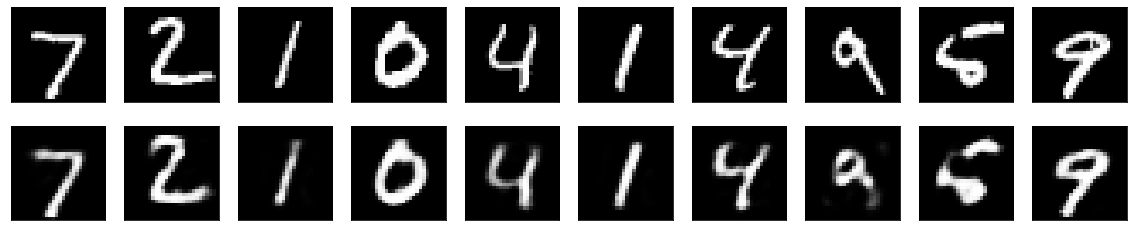

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
